In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-emotion-recognition/emotions.csv
/kaggle/input/facial-emotion-recognition/images/7/Disgust.jpg
/kaggle/input/facial-emotion-recognition/images/7/Anger.jpg
/kaggle/input/facial-emotion-recognition/images/7/Sad.jpg
/kaggle/input/facial-emotion-recognition/images/7/Surprised.jpg
/kaggle/input/facial-emotion-recognition/images/7/Neutral.jpg
/kaggle/input/facial-emotion-recognition/images/7/Happy.jpg
/kaggle/input/facial-emotion-recognition/images/7/Fear.jpg
/kaggle/input/facial-emotion-recognition/images/7/Contempt.jpg
/kaggle/input/facial-emotion-recognition/images/17/Disgust.jpg
/kaggle/input/facial-emotion-recognition/images/17/Anger.jpg
/kaggle/input/facial-emotion-recognition/images/17/Sad.jpg
/kaggle/input/facial-emotion-recognition/images/17/Surprised.jpg
/kaggle/input/facial-emotion-recognition/images/17/Neutral.jpg
/kaggle/input/facial-emotion-recognition/images/17/Happy.jpg
/kaggle/input/facial-emotion-recognition/images/17/Fear.jpg
/kaggle/input/facial-emoti

In [2]:
# Importing libraries for data handling, visualization, and deep learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import glob 

from skimage.io import imread
import cv2
from PIL import Image
from skimage.transform import resize
import itertools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import save_model

2025-05-31 23:40:01.994883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748734802.178822      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748734802.226249      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Loading the dataset
df = pd.read_csv('/kaggle/input/facial-emotion-recognition/emotions.csv')
df

,set_id,gender,age,country
0,0,FEMALE,36,RU
1,1,FEMALE,37,RU
2,2,FEMALE,36,RU
3,3,MALE,29,RU
4,4,FEMALE,43,RU
5,5,MALE,49,RU
6,6,FEMALE,38,RU
7,7,MALE,19,PH
8,8,FEMALE,29,RU
9,9,FEMALE,32,RU


In [4]:
# Loading image paths
images = glob.glob('/kaggle/input/facial-emotion-recognition/images/*/*.jpg')
print(len(images)) # Total number of images
print(images[0]) # Example path

152
/kaggle/input/facial-emotion-recognition/images/7/Disgust.jpg


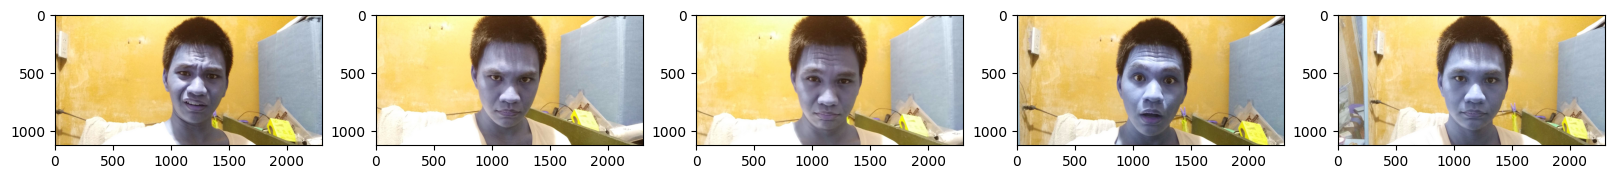

In [5]:
# Displaying some sample images
fig, axes = plt.subplots(1, 5, figsize=(20, 10))  
for i in range(5):
    img = cv2.imread(images[i])
    axes[i].imshow(img)      
plt.show()

In [6]:
# Creating a DataFrame for image paths and their respective emotions
image_data = pd.DataFrame(index=np.arange(0, len(images)), columns=['path', 'emotion'])
for i in range(len(images)):
    image_data.loc[i, 'path'] = images[i]
    image_data.loc[i, 'emotion'] = images[i][50:].replace(images[i][-4:], '')


image_data

,path,emotion
0,/kaggle/input/facial-emotion-recognition/image...,Disgust
1,/kaggle/input/facial-emotion-recognition/image...,Anger
2,/kaggle/input/facial-emotion-recognition/image...,Sad
3,/kaggle/input/facial-emotion-recognition/image...,Surprised
4,/kaggle/input/facial-emotion-recognition/image...,Neutral
...,...,...
147,/kaggle/input/facial-emotion-recognition/image...,/Surprised
148,/kaggle/input/facial-emotion-recognition/image...,/Neutral
149,/kaggle/input/facial-emotion-recognition/image...,/Happy
150,/kaggle/input/facial-emotion-recognition/image...,/Fear


In [8]:
# Standardizing the emotion column values by removing unnecessary prefixes to ensure consistency in emotion labels.
image_data['emotion'] = image_data['emotion'].replace('/Surprised', 'Surprised')
image_data['emotion'] = image_data['emotion'].replace('/Happy', 'Happy')
image_data['emotion'] = image_data['emotion'].replace('/Sad', 'Sad')
image_data['emotion'] = image_data['emotion'].replace('/Anger', 'Anger')
image_data['emotion'] = image_data['emotion'].replace('/Neutral', 'Neutral')
image_data['emotion'] = image_data['emotion'].replace('/Fear', 'Fear')
image_data['emotion'] = image_data['emotion'].replace('/Contempt', 'Contempt')
image_data['emotion'] = image_data['emotion'].replace('/Disgust', 'Disgust')

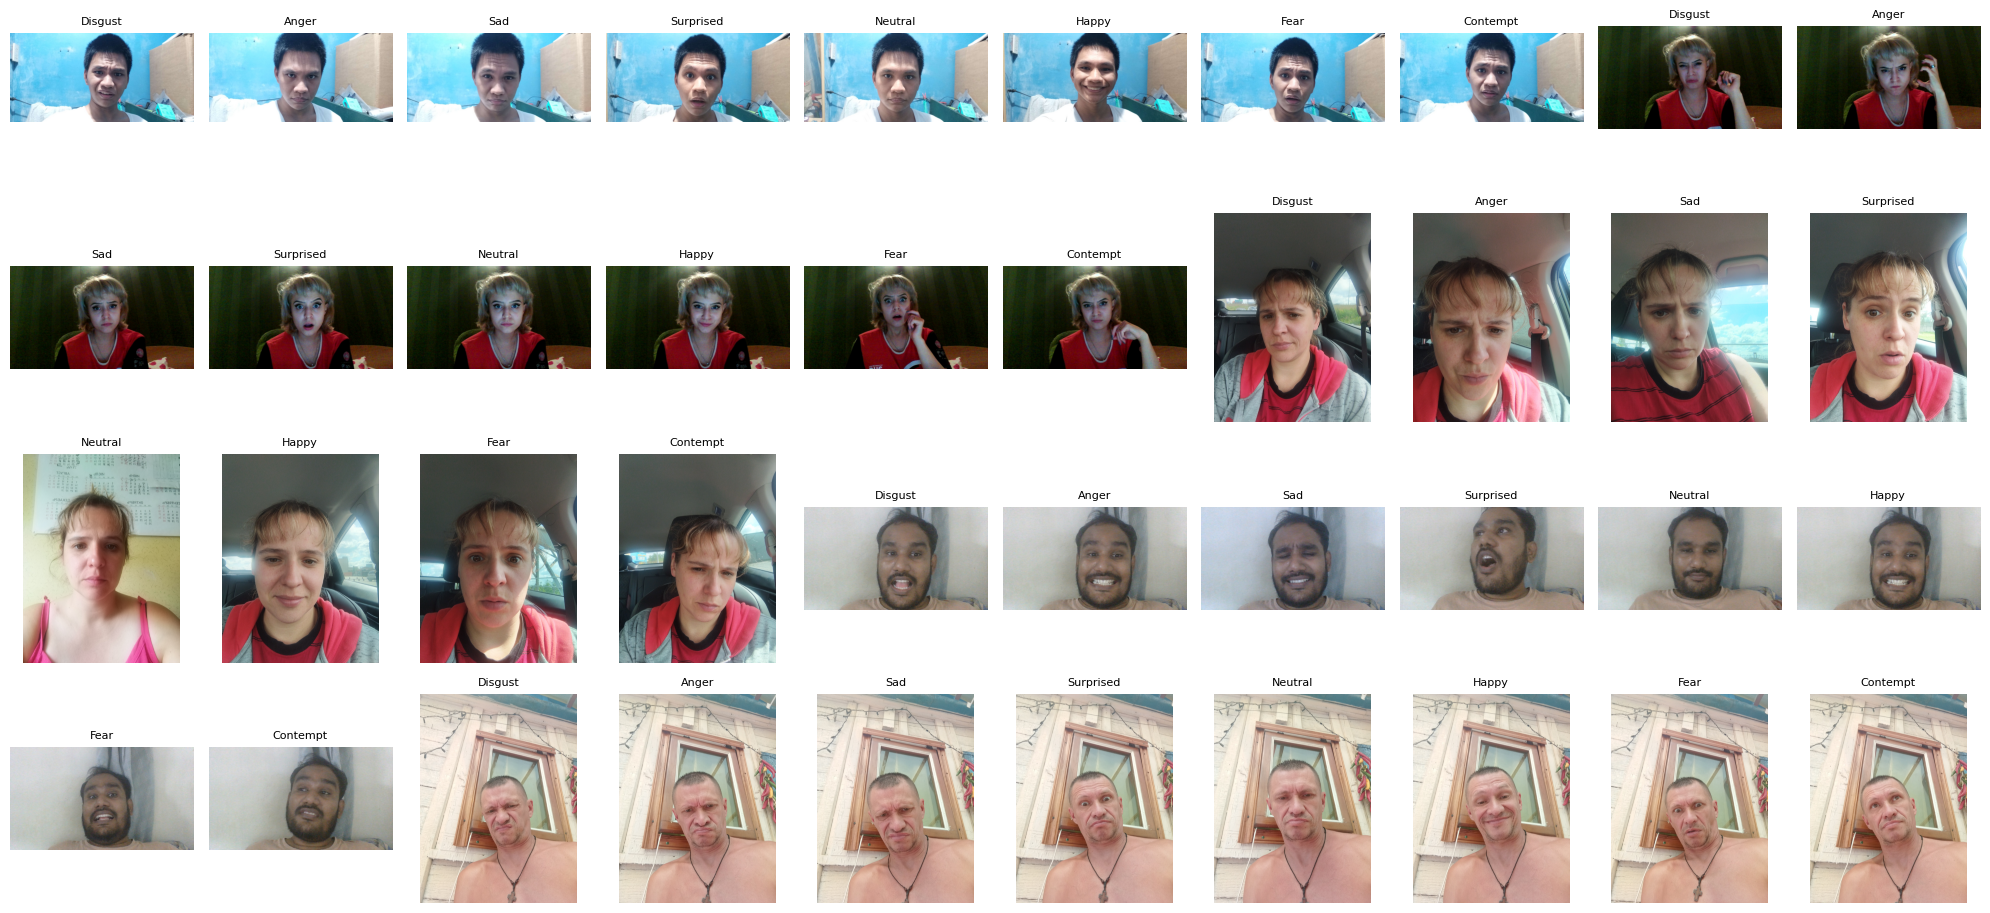

In [9]:
# Displaying a grid of 40 images (4 rows and 10 columns) with their corresponding emotion labels
fig, axes = plt.subplots(4, 10, figsize=(20, 10))
for i in range(4):
    for j in range(10):        
        image = imread(image_data.iloc[j + 10*i]["path"])
        axes[i, j].imshow(image)
        label = image_data.iloc[j + 10*i]["emotion"]
        axes[i, j].set_title(label, fontsize=8) 
        axes[i, j].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

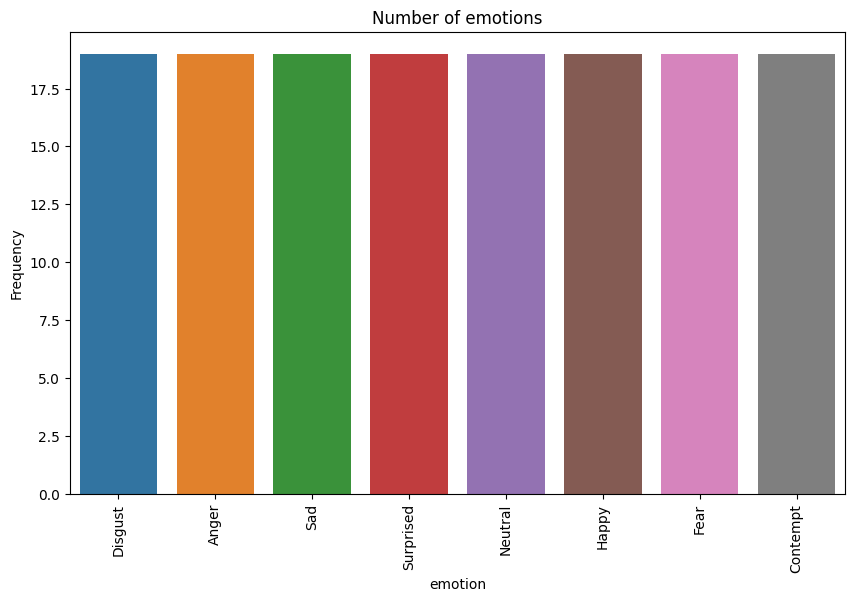

In [10]:
# Plotting the distribution of emotions to visualize the frequency of each emotion label in the dataset
plt.figure(figsize=(10, 6))
sns.barplot(x=image_data['emotion'].value_counts().index, y=image_data['emotion'].value_counts())
plt.title('Number of emotions')
plt.xlabel('emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [12]:
# Encoding the emotion labels as integers using LabelEncoder
label_encoder = LabelEncoder()
image_data['emotion'] = label_encoder.fit_transform(image_data['emotion'])
image_data

,path,emotion
0,/kaggle/input/facial-emotion-recognition/image...,2
1,/kaggle/input/facial-emotion-recognition/image...,0
2,/kaggle/input/facial-emotion-recognition/image...,6
3,/kaggle/input/facial-emotion-recognition/image...,7
4,/kaggle/input/facial-emotion-recognition/image...,5
...,...,...
147,/kaggle/input/facial-emotion-recognition/image...,7
148,/kaggle/input/facial-emotion-recognition/image...,5
149,/kaggle/input/facial-emotion-recognition/image...,4
150,/kaggle/input/facial-emotion-recognition/image...,3


In [13]:
# Loading and resizing images to 224x224 pixels and preparing feature (X) and label (y) arrays
X = []
y = []
for feature, label in image_data.values:
    image = cv2.imread(feature)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
    X.append(image)
    y.append(label)
X = np.array(X)
y = np.array(y)

In [15]:
# Print shape of input data (X) and output data (y)
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (152, 224, 224, 3)
Shape of y: (152,)


In [16]:
# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,        
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    shear_range=0.2,          
    zoom_range=0.2,           
    horizontal_flip=True,     
    fill_mode='nearest'       
)

In [17]:
# Applying augmentation to images
augmented_X = []
augmented_y = []
for i in range(len(X)):
    img = X[i].reshape((1, *X[i].shape))  
    label = y[i]
    for _ in range(50):  
        augmented = next(datagen.flow(img, batch_size=1))
        augmented_X.append(augmented[0])  
        augmented_y.append(label)        
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

In [18]:
# Combining original and augmented data
X = np.concatenate([X, augmented_X], axis=0)
y = np.concatenate([y, augmented_y], axis=0)

In [19]:
# Print shape of input data (X) and output data (y) after augmentation
print(X.shape)  
print(y.shape)

(7752, 224, 224, 3)
(7752,)


In [20]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [21]:
print(f'Length of Training Data: {len(X_train)}')
print(f'Length of Testing Data: {len(X_test)}')

Length of Training Data: 6201
Length of Testing Data: 1551


In [22]:
y_train = to_categorical(y_train, num_classes = 8)
y_test = to_categorical(y_test, num_classes = 8)

In [23]:
# Building the model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, mode='max', verbose=1, factor=0.5, min_lr=0.0001)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(8, activation='softmax')
])

I0000 00:00:1748735006.569544      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748735006.570310      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,770,184 (94.49 MB)

 Trainable params: 1,182,472 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [25]:
# Training the model
history = model.fit(
    X_train, y_train, batch_size=20, validation_data=(X_test, y_test), epochs=25, callbacks=[early_stopping, lr_reduction]
)

Epoch 1/25


I0000 00:00:1748735294.288340     117 service.cc:148] XLA service 0x78c0280524a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748735294.289041     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748735294.289064     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748735295.819553     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/311 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.2806 - loss: 2.5217 

I0000 00:00:1748735300.242693     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


311/311 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - accuracy: 0.1862 - loss: 2.1896 - val_accuracy: 0.4210 - val_loss: 1.5556 - learning_rate: 0.0010
Epoch 2/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.4741 - loss: 1.4071 - val_accuracy: 0.5828 - val_loss: 1.1018 - learning_rate: 0.0010
Epoch 3/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.6912 - loss: 0.8630 - val_accuracy: 0.7498 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 4/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.8150 - loss: 0.5223 - val_accuracy: 0.7286 - val_loss: 0.7382 - learning_rate: 0.0010
Epoch 5/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.8422 - loss: 0.4232 - val_accuracy: 0.7956 - val_loss: 0.5360 - learning_rate: 0.0010
Epoch 6/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.8946 - loss: 0.3086 - val_accuracy: 0.8272 - val_loss: 0.4699 - learning_rate: 0.0010
Epoch 7/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.9230 - loss: 0.220

In [26]:
# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
print("Loss:", loss)

49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.9407 - loss: 0.1800
Test Accuracy: 0.9419729113578796
Loss: 0.18218329548835754


In [27]:
# Classification report
y_pred = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       206
           1       0.93      0.93      0.93       215
           2       0.96      0.97      0.96       203
           3       0.97      0.94      0.95       176
           4       0.91      0.94      0.93       179
           5       0.92      0.97      0.94       184
           6       0.96      0.92      0.94       194
           7       0.95      0.95      0.95       194

    accuracy                           0.94      1551
   macro avg       0.94      0.94      0.94      1551
weighted avg       0.94      0.94      0.94      1551



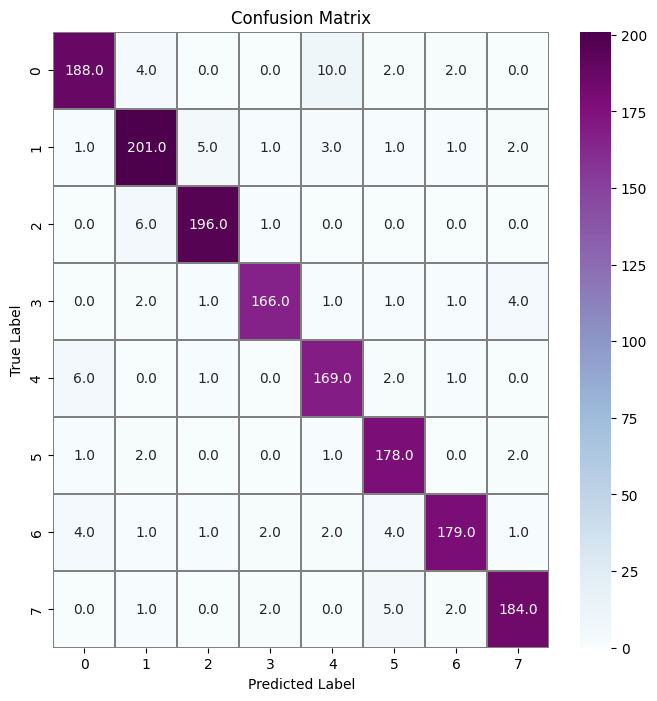

In [28]:
# Confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

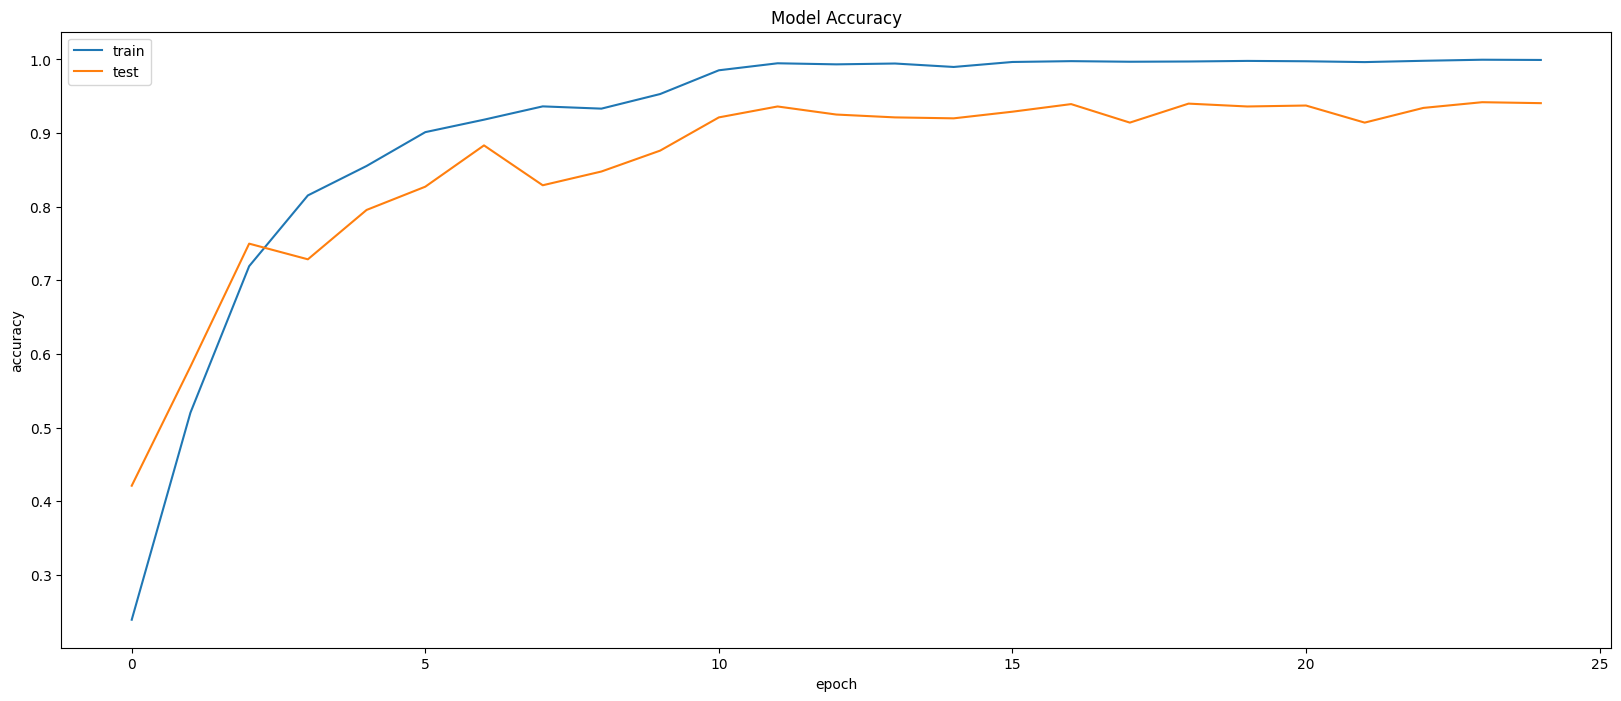

In [29]:
# Accuracy plot
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

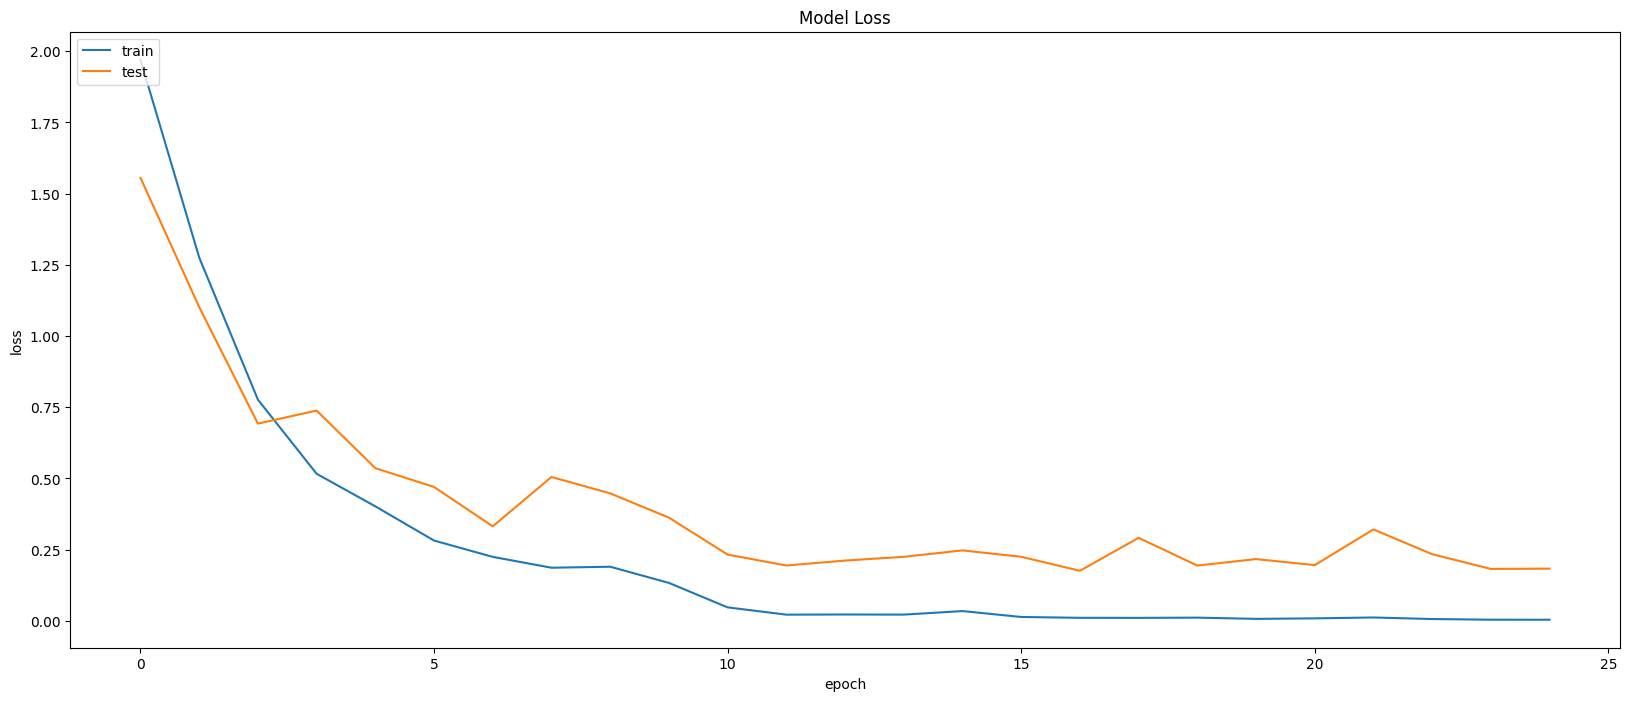

In [30]:
# Loss plot
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()